In [ ]:
# Based on this tutorial: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb

In [268]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d, EnsureTyped,SaveImage,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
import sys
import nibabel as nib
import torch

In [269]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp1ihctr5u


In [270]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            #pixdim=(0.54, 0.54, 0.195), # funciona
            pixdim=(0.175781, 0.175781, 0.39),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=10000,
            a_max=400000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
           keys=["image", "label"],
           label_key="label",
            #spatial_size=(32, 32, 16),
            spatial_size=(32, 32, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
           image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.175781, 0.175781, 0.39),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=10000, a_max=400000, b_min=0.0, b_max=1.0, clip=True),

        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=10000, a_max=400000, b_min=0.0, b_max=1.0, clip=True),

        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
    
    
)

In [273]:
data_dir = "/mnt/d/crmbm/multiclass/z_1"
split_json = "/config.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=52,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=12, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Load test DS

test_files = load_decathlon_datalist(datasets, True, "test")
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=12, cache_rate=1.0, num_workers=0)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.04it/s]


image shape: torch.Size([1, 96, 96, 47]), label shape: torch.Size([1, 96, 96, 47])


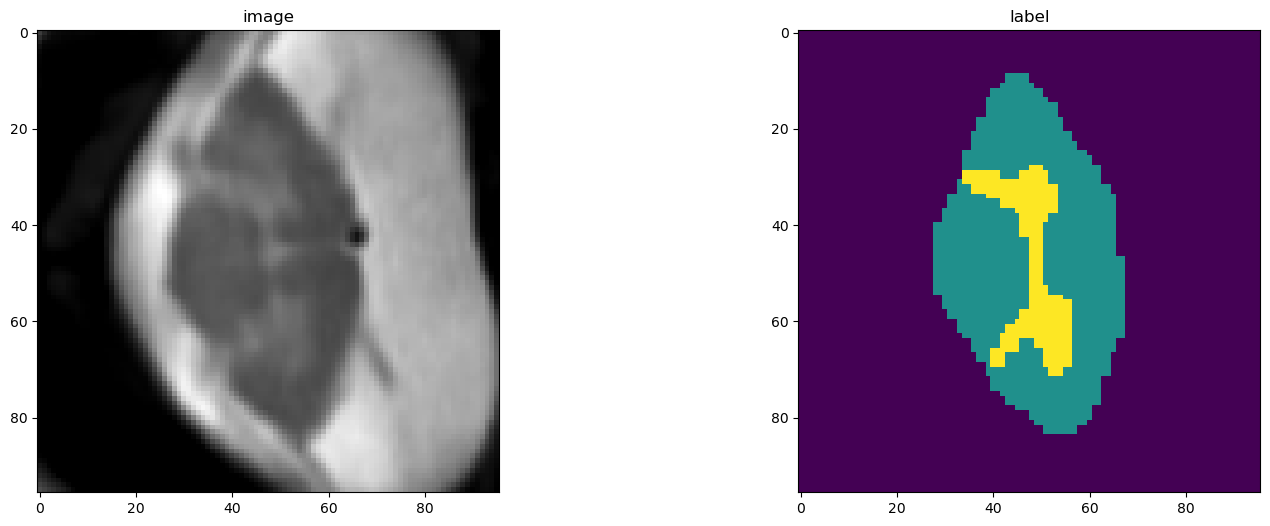

1


In [274]:
slice_map = {
    "sub-26_T2star.nii.gz": 1,
    "sub-45_T2star.nii.gz": 1,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()
print(slice_map[img_name])

image shape: torch.Size([1, 32, 32, 16]), label shape: torch.Size([1, 32, 32, 16])


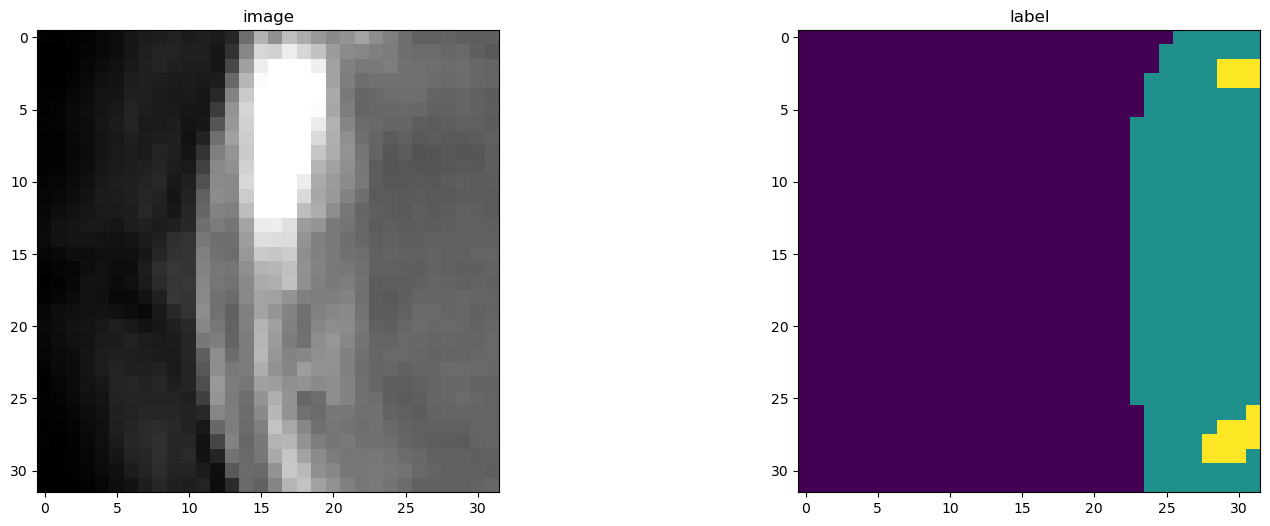

In [275]:
# Training cropped
case_num = 0
data_show=train_ds[case_num][0]
img, label = data_show["image"],data_show["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 0])
plt.show()

In [20]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(32, 32, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [21]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (32, 32, 16), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [22]:
max_iterations = 2500
eval_num = 50
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (50 / 2500 Steps) (loss=1.68952):  29%|████████████                              | 2/7 [00:07<00:19,  3.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33134138584136963 Current Avg. Dice: 0.33134138584136963


Training (100 / 2500 Steps) (loss=1.55456):  43%|█████████████████▌                       | 3/7 [00:05<00:08,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.44397103786468506 Current Avg. Dice: 0.44397103786468506


Training (150 / 2500 Steps) (loss=1.40001):  57%|███████████████████████▍                 | 4/7 [00:05<00:05,  1.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.499948114156723 Current Avg. Dice: 0.499948114156723


Training (200 / 2500 Steps) (loss=1.38079):  71%|█████████████████████████████▎           | 5/7 [00:06<00:03,  1.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5367292761802673 Current Avg. Dice: 0.5367292761802673


Training (251 / 2500 Steps) (loss=1.39910): 100%|█████████████████████████████████████████| 7/7 [00:07<00:00,  1.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5480291843414307 Current Avg. Dice: 0.5480291843414307


Training (300 / 2500 Steps) (loss=1.51561): 100%|█████████████████████████████████████████| 7/7 [00:06<00:00,  1.07it/s]


Model Was Saved ! Current Best Avg. Dice: 0.609727144241333 Current Avg. Dice: 0.609727144241333


Training (350 / 2500 Steps) (loss=1.22272):  14%|█████▊                                   | 1/7 [00:04<00:27,  4.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6937575936317444 Current Avg. Dice: 0.6937575936317444


Training (400 / 2500 Steps) (loss=1.16226):  29%|███████████▋                             | 2/7 [00:05<00:14,  2.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6973363757133484 Current Avg. Dice: 0.6973363757133484


Training (450 / 2500 Steps) (loss=1.15246):  43%|█████████████████▌                       | 3/7 [00:05<00:08,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7547411322593689 Current Avg. Dice: 0.7547411322593689


Training (500 / 2500 Steps) (loss=1.12003):  57%|███████████████████████▍                 | 4/7 [00:05<00:04,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7547411322593689 Current Avg. Dice: 0.7365829944610596


Training (550 / 2500 Steps) (loss=1.12501):  71%|█████████████████████████████▎           | 5/7 [00:05<00:02,  1.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7547411322593689 Current Avg. Dice: 0.7183509469032288


Training (601 / 2500 Steps) (loss=1.21154): 100%|█████████████████████████████████████████| 7/7 [00:06<00:00,  1.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7635969519615173 Current Avg. Dice: 0.7635969519615173


Training (650 / 2500 Steps) (loss=1.02797): 100%|█████████████████████████████████████████| 7/7 [00:05<00:00,  1.20it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7635969519615173 Current Avg. Dice: 0.745389997959137


Training (700 / 2500 Steps) (loss=0.96920):  14%|█████▊                                   | 1/7 [00:05<00:33,  5.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7635969519615173 Current Avg. Dice: 0.7595840692520142


Training (750 / 2500 Steps) (loss=1.00870):  29%|███████████▋                             | 2/7 [00:05<00:14,  2.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7635969519615173 Current Avg. Dice: 0.7553053498268127


Training (800 / 2500 Steps) (loss=1.09695):  43%|█████████████████▌                       | 3/7 [00:04<00:07,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7635969519615173 Current Avg. Dice: 0.7400916814804077


Training (850 / 2500 Steps) (loss=1.02016):  57%|███████████████████████▍                 | 4/7 [00:05<00:05,  1.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7832887768745422 Current Avg. Dice: 0.7832887768745422


Training (900 / 2500 Steps) (loss=0.89302):  71%|█████████████████████████████▎           | 5/7 [00:05<00:03,  1.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7860950231552124 Current Avg. Dice: 0.7860950231552124


Training (951 / 2500 Steps) (loss=1.15387): 100%|█████████████████████████████████████████| 7/7 [00:06<00:00,  1.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7860950231552124 Current Avg. Dice: 0.7738859057426453


Training (1000 / 2500 Steps) (loss=1.05906): 100%|████████████████████████████████████████| 7/7 [00:06<00:00,  1.15it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7860950231552124 Current Avg. Dice: 0.7701641321182251


Training (1050 / 2500 Steps) (loss=0.99279):  14%|█████▋                                  | 1/7 [00:05<00:31,  5.29s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7882025241851807 Current Avg. Dice: 0.7882025241851807


Training (1100 / 2500 Steps) (loss=0.78809):  29%|███████████▍                            | 2/7 [00:05<00:14,  2.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7988607287406921 Current Avg. Dice: 0.7988607287406921


Training (1150 / 2500 Steps) (loss=0.89014):  43%|█████████████████▏                      | 3/7 [00:04<00:07,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7988607287406921 Current Avg. Dice: 0.7841956615447998


Training (1200 / 2500 Steps) (loss=0.99962):  57%|██████████████████████▊                 | 4/7 [00:05<00:05,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7988607287406921 Current Avg. Dice: 0.7868059277534485


Training (1250 / 2500 Steps) (loss=0.95957):  71%|████████████████████████████▌           | 5/7 [00:05<00:03,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8002125024795532 Current Avg. Dice: 0.8002125024795532


Training (1301 / 2500 Steps) (loss=0.83774): 100%|████████████████████████████████████████| 7/7 [00:06<00:00,  1.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8011834621429443 Current Avg. Dice: 0.8011834621429443


Training (1350 / 2500 Steps) (loss=0.69499): 100%|████████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s]


Model Was Saved ! Current Best Avg. Dice: 0.8064823746681213 Current Avg. Dice: 0.8064823746681213


Training (1400 / 2500 Steps) (loss=0.85536):  14%|█████▋                                  | 1/7 [00:04<00:28,  4.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.81146639585495 Current Avg. Dice: 0.81146639585495


Training (1450 / 2500 Steps) (loss=0.75882):  29%|███████████▍                            | 2/7 [00:04<00:12,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.81146639585495 Current Avg. Dice: 0.808427095413208


Training (1500 / 2500 Steps) (loss=0.84255):  43%|█████████████████▏                      | 3/7 [00:05<00:08,  2.10s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8163575530052185 Current Avg. Dice: 0.8163575530052185


Training (1550 / 2500 Steps) (loss=0.69800):  57%|██████████████████████▊                 | 4/7 [00:05<00:04,  1.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8163575530052185 Current Avg. Dice: 0.8138827681541443


Training (1600 / 2500 Steps) (loss=0.81738):  71%|████████████████████████████▌           | 5/7 [00:06<00:03,  1.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8164225220680237


Training (1651 / 2500 Steps) (loss=1.05494): 100%|████████████████████████████████████████| 7/7 [00:06<00:00,  1.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8017892241477966


Training (1700 / 2500 Steps) (loss=0.65195): 100%|████████████████████████████████████████| 7/7 [00:05<00:00,  1.17it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8089268207550049


Training (1750 / 2500 Steps) (loss=0.80908):  14%|█████▋                                  | 1/7 [00:04<00:26,  4.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.7917594313621521


Training (1800 / 2500 Steps) (loss=0.86226):  29%|███████████▍                            | 2/7 [00:04<00:12,  2.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.7883405089378357


Training (1850 / 2500 Steps) (loss=0.81442):  43%|█████████████████▏                      | 3/7 [00:05<00:08,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.812376081943512


Training (1900 / 2500 Steps) (loss=0.79240):  57%|██████████████████████▊                 | 4/7 [00:05<00:04,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8065515160560608


Training (1950 / 2500 Steps) (loss=0.87769):  71%|████████████████████████████▌           | 5/7 [00:07<00:04,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8073303699493408


Training (2000 / 2500 Steps) (loss=0.68948):  86%|██████████████████████████████████▎     | 6/7 [00:07<00:01,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8164225220680237 Current Avg. Dice: 0.8134985566139221


Training (2050 / 2500 Steps) (loss=0.67926): 100%|████████████████████████████████████████| 7/7 [00:07<00:00,  1.02s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8205621242523193 Current Avg. Dice: 0.8205621242523193


Training (2100 / 2500 Steps) (loss=0.63971):  14%|█████▋                                  | 1/7 [00:04<00:27,  4.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8205621242523193 Current Avg. Dice: 0.8199020624160767


Training (2150 / 2500 Steps) (loss=0.76728):  29%|███████████▍                            | 2/7 [00:09<00:25,  5.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8205621242523193 Current Avg. Dice: 0.8089230060577393


Training (2200 / 2500 Steps) (loss=0.71005):  43%|█████████████████▏                      | 3/7 [00:05<00:09,  2.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8205621242523193 Current Avg. Dice: 0.8151941895484924


Training (2250 / 2500 Steps) (loss=0.62835):  57%|██████████████████████▊                 | 4/7 [00:07<00:06,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8228790760040283 Current Avg. Dice: 0.8228790760040283


Training (2300 / 2500 Steps) (loss=0.63710):  71%|████████████████████████████▌           | 5/7 [00:06<00:03,  1.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8228790760040283 Current Avg. Dice: 0.8040525317192078


Training (2351 / 2500 Steps) (loss=0.75705): 100%|████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8228790760040283 Current Avg. Dice: 0.8134050965309143


Training (2400 / 2500 Steps) (loss=0.91264): 100%|████████████████████████████████████████| 7/7 [00:07<00:00,  1.00s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8259744048118591 Current Avg. Dice: 0.8259744048118591


Training (2450 / 2500 Steps) (loss=0.80912):  14%|█████▋                                  | 1/7 [00:04<00:28,  4.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8259744048118591 Current Avg. Dice: 0.8222812414169312


Training (2500 / 2500 Steps) (loss=0.68641):  29%|███████████▍                            | 2/7 [00:04<00:12,  2.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8259744048118591 Current Avg. Dice: 0.8233158588409424


Training (2505 / 2500 Steps) (loss=0.78910): 100%|████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


<All keys matched successfully>

In [23]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8260 at iteration: 2400


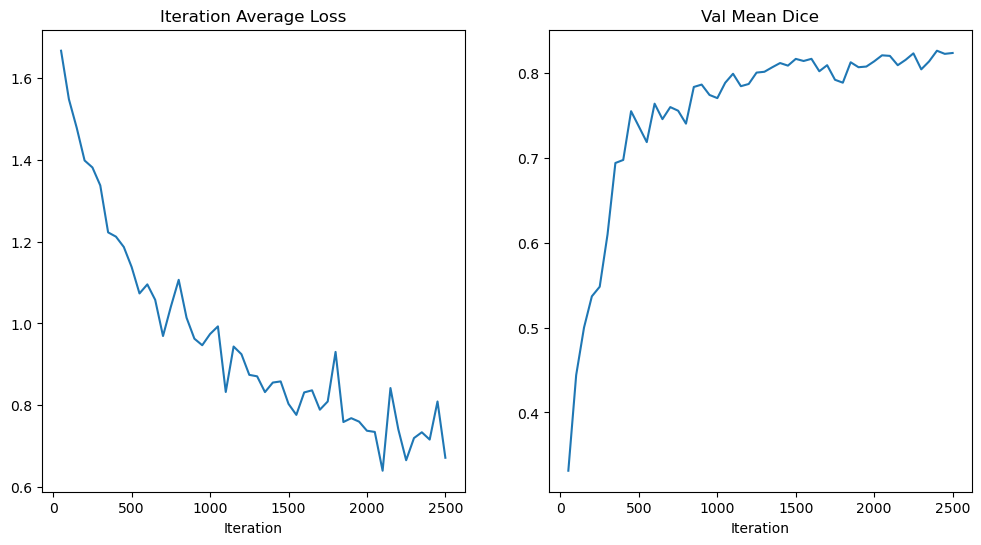

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

image shape: torch.Size([1, 96, 96, 47]), label shape: torch.Size([1, 96, 96, 47])


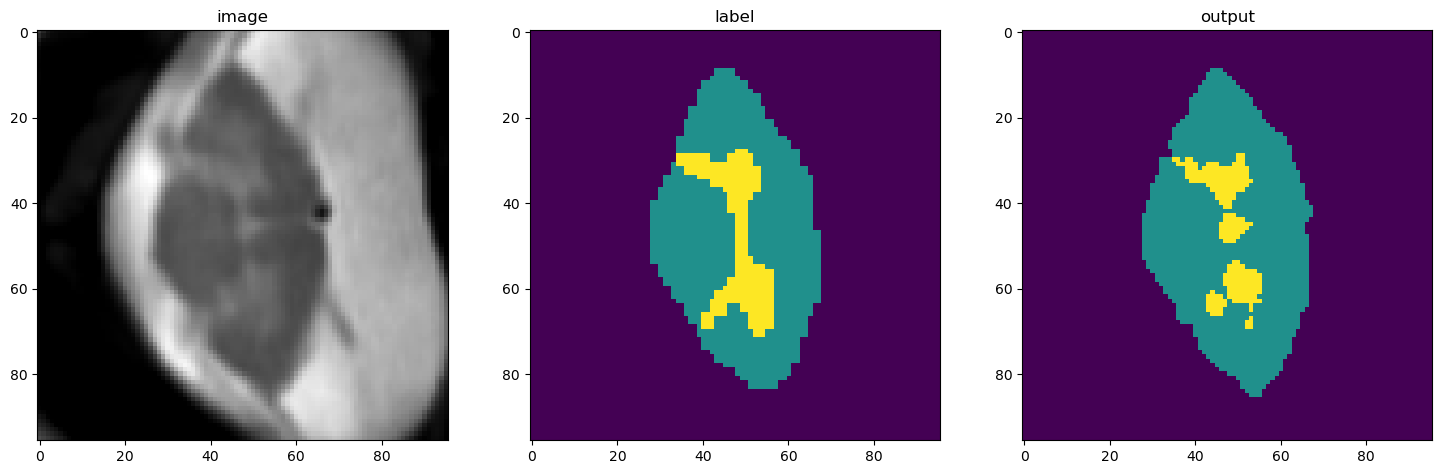

1


In [25]:
# Validation DS
case_num = 0
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")

    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (32, 32, 16), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()
print(slice_map[img_name])

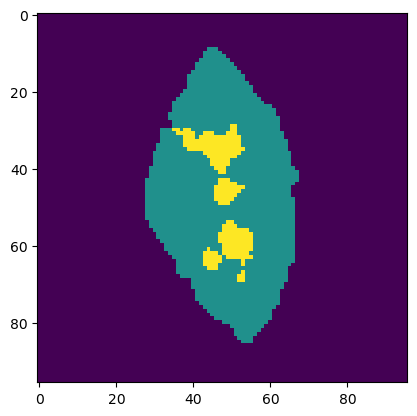

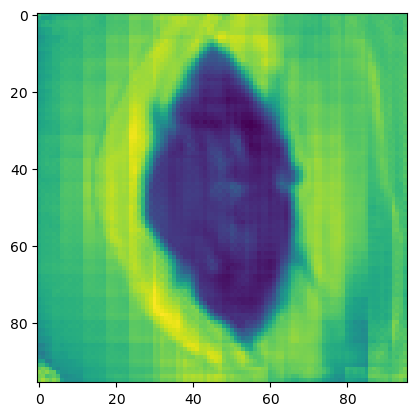

In [26]:
plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 1])
plt.show()
plt.imshow((val_outputs).detach().cpu()[0,0, :, :, 1])

In [158]:
# save the model
data_dir = "/mnt/d/crmbm/multiclass/"
torch.save(model.state_dict(), data_dir + 'seg_model_7T.pth')

In [276]:
# load model saved
data_dir = "/mnt/d/crmbm/multiclass/"
model_new = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(32, 32, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

model_new.load_state_dict(torch.load(os.path.join(data_dir + 'seg_model_7T.pth')))

<All keys matched successfully>

image shape: torch.Size([1, 96, 96, 22]), label shape: torch.Size([1, 96, 96, 22])


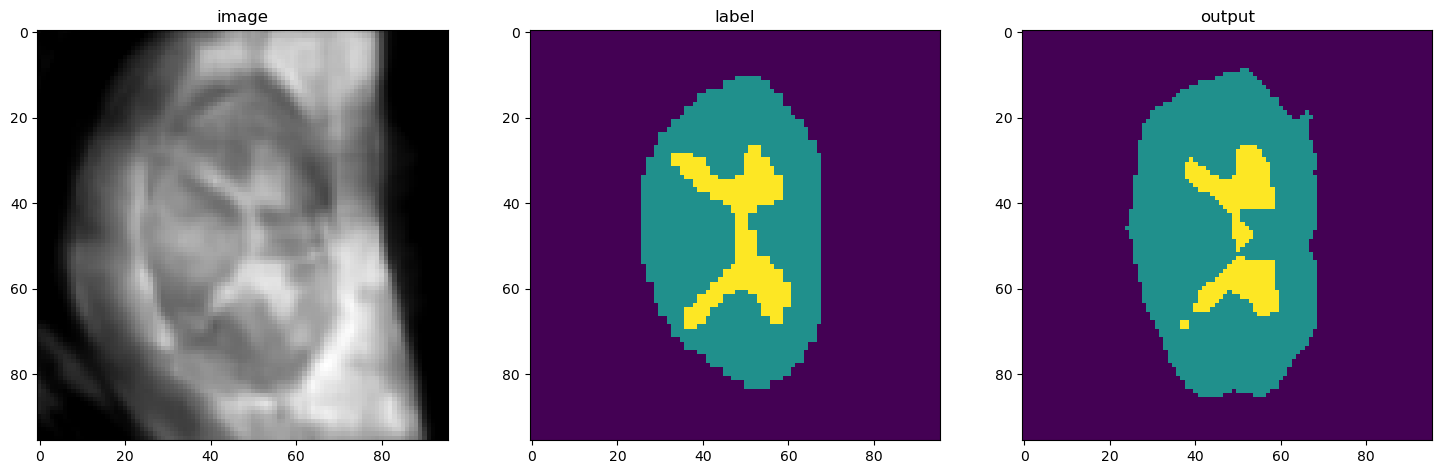

12


In [288]:
#Test DS
case_num = 0
#model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model_new.load_state_dict(torch.load(os.path.join(data_dir + 'seg_model_7T.pth')))
model_new.eval()
slice_map = {
    "sub-31_T2star.nii.gz": 12,
    "sub-32_T2star.nii.gz": 1,
}
with torch.no_grad():
    to_test=test_ds[case_num]
    img_name = os.path.split(to_test["image"].meta["filename_or_obj"])[1]
    img = to_test["image"]
    label = to_test["label"]
    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (32, 32, 16), 4, model_new, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()
print(slice_map[img_name])

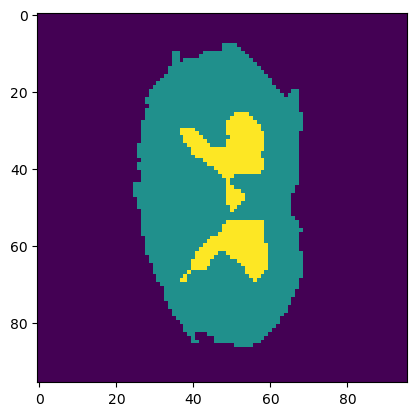

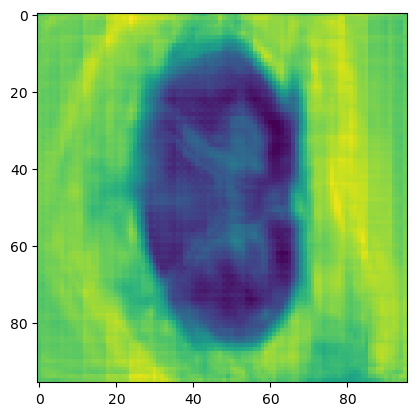

In [286]:
plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 10])
plt.show()
plt.imshow((val_outputs).detach().cpu()[0,0, :, :, 10])

In [281]:
path_database = '/mnt/d/crmbm/multiclass/z_1/'
test_data = nib.load(path_database + 'sub-31_T2star.nii.gz' )
header_info = test_data.header

test_data = np.array(test_data.get_fdata())

save_nii=torch.argmax(val_outputs, dim=1).detach().cpu().numpy()[0, :, :,:]

save = nib.Nifti1Image(save_nii, header_data.affine,header_info)    
nib.save(save, path_database + 'sub-31_T2star_UNETR.nii.gz')

In [282]:
SaveImage(output_dir=path_database, output_postfix='trans', output_ext='.nii.gz'
          )

In [254]:
test_data_array = np.expand_dims(test_data, axis=-4)
test_data_array = np.expand_dims(test_data_array, axis=-4)
test_data_tensor = torch.tensor(test_data_array[:,:,:,:,0:16])
test_data_tensor.shape

torch.Size([1, 1, 96, 96, 16])